VIDEO MP4
   ↓
Extracción de frames
   ↓
Segmentación de pallets (SAM)
   ↓
df_pallets
   ↓
Detección de cajas dentro de cada pallet
   ↓
df_boxes
   ↓
Estimación de cajas ocultas
   ↓
df_inference
   ↓
Feature Engineering (tu código actual)
   ↓
df_final listo para ML


1️⃣ Montar Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2️⃣ Instalar dependencias

In [4]:
!pip install segment-anything opencv-python matplotlib seaborn scikit-learn

3️⃣ Definir paths

In [5]:
import os

BASE_DIR = "/content/drive/MyDrive/drone_pipeline"

VIDEO_PATH = "/content/drive/MyDrive/pallet_counting_project/data/raw_videos/DJI_20251227113309_0010_D.MP4"
SAM_CHECKPOINT = "/content/sam_vit_b_01ec64.pth"

FRAMES_DIR = f"{BASE_DIR}/frames"
GOOD_FRAMES_DIR = f"{BASE_DIR}/good_frames"
RESULTS_DIR = f"{BASE_DIR}/results"
DATASET_DIR = f"{BASE_DIR}/datasets"

os.makedirs(FRAMES_DIR, exist_ok=True)
os.makedirs(GOOD_FRAMES_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)

print("Directorios listos")


Directorios listos


In [6]:
# Descargar checkpoint oficial SAM ViT-B
!wget -O /content/sam_vit_b_01ec64.pth \
https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2026-02-06 21:17:41--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.13, 3.171.22.68, 3.171.22.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘/content/sam_vit_b_01ec64.pth’

/content/sam_vit_b_ 100%[===================>] 357.67M   201MB/s    in 1.8s    

2026-02-06 21:17:43 (201 MB/s) - ‘/content/sam_vit_b_01ec64.pth’ saved [375042383/375042383]



4️⃣ Extraer frames del video

In [8]:
import cv2

cap = cv2.VideoCapture(VIDEO_PATH)

frame_id = 0
saved = 0

while True:

    ret, frame = cap.read()

    if not ret:
        break

    if frame_id % 5 == 0:  # reducir carga

        frame_name = f"frame_{frame_id:05d}.jpg"

        cv2.imwrite(
            os.path.join(GOOD_FRAMES_DIR, frame_name),
            frame
        )

        saved += 1

    frame_id += 1

cap.release()

print("Frames guardados:", saved)


KeyboardInterrupt: 

5️⃣ Cargar SAM

In [9]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

model_type = "vit_b"

sam = sam_model_registry[model_type](
    checkpoint=SAM_CHECKPOINT
)

sam.to(device="cpu")

mask_generator = SamAutomaticMaskGenerator(
    sam,
    min_mask_region_area=5000
)

print("SAM listo")


SAM listo


In [ ]:
6️⃣ Detectar pallets → df_pallets

Selecciona solo pocos frames para evitar acabarse la RAM


In [10]:
import os
import shutil
import random

# Ruta real donde están tus 495 frames
SOURCE_DIR = "/content/drive/MyDrive/drone_pipeline/good_frames"

# Carpeta destino para los frames seleccionados
SELECTED_DIR = "/content/drive/MyDrive/drone_pipeline/selected_frames"

# Crear carpeta si no existe
os.makedirs(SELECTED_DIR, exist_ok=True)

# Obtener lista de todos los frames
frames = os.listdir(SOURCE_DIR)

print(f"Total frames disponibles: {len(frames)}")

# Seleccionar 5 frames aleatorios
selected_frames = random.sample(frames, 3)

# Copiar los frames seleccionados
for frame in selected_frames:

    src = os.path.join(SOURCE_DIR, frame)
    dst = os.path.join(SELECTED_DIR, frame)

    shutil.copy(src, dst)

print("\nFrames seleccionados aleatoriamente:")
for f in selected_frames:
    print(f)



Total frames disponibles: 495

Frames seleccionados aleatoriamente:
frame_01435.jpg
frame_02260.jpg
frame_00715.jpg


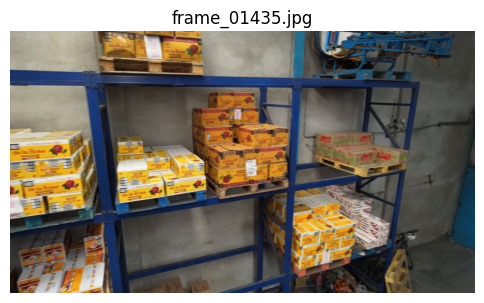

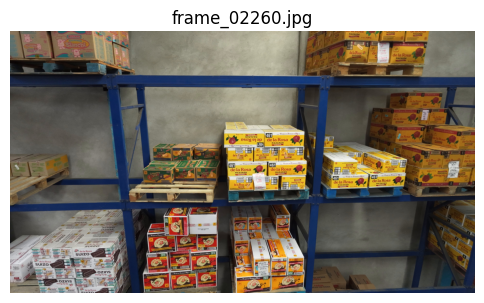

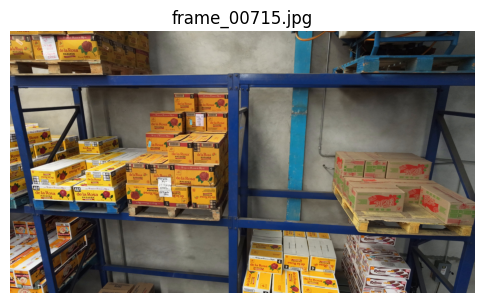

In [11]:
import cv2
import matplotlib.pyplot as plt

for frame in selected_frames:

    img = cv2.imread(os.path.join(SELECTED_DIR, frame))

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title(frame)
    plt.axis("off")
    plt.show()


In [12]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

SAM_CHECKPOINT = "/content/sam_vit_b_01ec64.pth"

model_type = "vit_b"

sam = sam_model_registry[model_type](
    checkpoint=SAM_CHECKPOINT
)

# usar CPU para evitar crash de RAM
sam.to(device="cpu")

mask_generator = SamAutomaticMaskGenerator(
    sam,
    min_mask_region_area=5000
)

print("SAM cargado correctamente")


SAM cargado correctamente


In [13]:
import pandas as pd
import numpy as np

records = []

frames = sorted(os.listdir(SELECTED_DIR))

for frame_name in frames:

    frame_path = os.path.join(SELECTED_DIR, frame_name)

    img = cv2.imread(frame_path)

    # REDUCIR tamaño para evitar crash RAM
    scale = 640 / max(img.shape[:2])

    if scale < 1:
        img = cv2.resize(img, None, fx=scale, fy=scale)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    masks = mask_generator.generate(img_rgb)

    pallet_id = 0

    for mask in masks:

        y_indices, x_indices = np.where(mask["segmentation"])

        xmin = int(np.min(x_indices))
        xmax = int(np.max(x_indices))
        ymin = int(np.min(y_indices))
        ymax = int(np.max(y_indices))

        area = int(mask["area"])

        records.append({

            "frame": frame_name,
            "pallet_id": pallet_id,

            "bbox_xmin": xmin,
            "bbox_ymin": ymin,
            "bbox_xmax": xmax,
            "bbox_ymax": ymax,

            "mask_area": area

        })

        pallet_id += 1

df_pallets = pd.DataFrame(records)

print("df_pallets creado:", df_pallets.shape)

df_pallets.head()


df_pallets creado: (890, 7)


,frame,pallet_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,mask_area
0,frame_00010.jpg,0,460,187,639,358,28213
1,frame_00010.jpg,1,45,0,167,65,4946
2,frame_00010.jpg,2,602,326,639,359,862
3,frame_00010.jpg,3,0,317,85,352,868
4,frame_00010.jpg,4,368,309,383,337,401


In [15]:
records = []

for index, row in df_pallets.iterrows():

    num_boxes = np.random.randint(5,20)

    box_coords = []

    for i in range(num_boxes):

        box_coords.append((
            np.random.randint(0,100),
            np.random.randint(0,100),
            np.random.randint(20,80),
            np.random.randint(20,80)
        ))

    records.append({

        "frame": row["frame"],
        "pallet_id": row["pallet_id"],
        "num_boxes_visible": num_boxes,
        "box_coords": box_coords

    })

df_boxes = pd.DataFrame(records)


In [16]:
df_inference = df_boxes.copy()

df_inference["hidden_boxes_estimated"] = (

    df_inference["num_boxes_visible"] * 0.35

).astype(int)

df_inference["total_boxes_estimated"] = (

    df_inference["num_boxes_visible"]
    +
    df_inference["hidden_boxes_estimated"]

)

print("df_inference creado")

df_inference.head()


df_inference creado


,frame,pallet_id,num_boxes_visible,box_coords,hidden_boxes_estimated,total_boxes_estimated
0,frame_00010.jpg,0,19,"[(95, 68, 60, 76), (14, 46, 65, 39), (31, 54, ...",6,25
1,frame_00010.jpg,1,8,"[(20, 46, 66, 69), (66, 55, 67, 71), (42, 99, ...",2,10
2,frame_00010.jpg,2,11,"[(38, 63, 50, 65), (20, 65, 40, 25), (58, 62, ...",3,14
3,frame_00010.jpg,3,14,"[(51, 84, 72, 51), (9, 75, 21, 69), (56, 35, 3...",4,18
4,frame_00010.jpg,4,11,"[(84, 34, 55, 55), (69, 94, 36, 55), (7, 67, 7...",3,14


In [17]:
df = df_pallets.merge(
    df_boxes,
    on=["frame","pallet_id"]
)

df = df.merge(
    df_inference[
        ["frame","pallet_id",
         "hidden_boxes_estimated",
         "total_boxes_estimated"]
    ],
    on=["frame","pallet_id"]
)

# ============================================
# CREACIÓN DE NUEVAS FEATURES
# ============================================

df["bbox_width"] = df["bbox_xmax"] - df["bbox_xmin"]

df["bbox_height"] = df["bbox_ymax"] - df["bbox_ymin"]

df["aspect_ratio"] = (
    df["bbox_width"] /
    df["bbox_height"]
)

df["mask_density"] = (
    df["mask_area"] /
    (df["bbox_width"] * df["bbox_height"])
)

# Feature estadística importante
avg_box_area = []

for coords in df["box_coords"]:

    areas = [w*h for (_,_,w,h) in coords]

    avg_box_area.append(np.mean(areas))

df["avg_box_area"] = avg_box_area

# Feature temporal
df["frame_index"] = (
    df["frame"]
    .str.extract('(\d+)')
    .astype(int)
)

print("Feature Engineering completado")

df.head()


Feature Engineering completado


<>:47: SyntaxWarning: invalid escape sequence '\d'
<>:47: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1677200317.py:47: SyntaxWarning: invalid escape sequence '\d'
  .str.extract('(\d+)')


,frame,pallet_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,mask_area,num_boxes_visible,box_coords,hidden_boxes_estimated,total_boxes_estimated,bbox_width,bbox_height,aspect_ratio,mask_density,avg_box_area,frame_index
0,frame_00010.jpg,0,460,187,639,358,28213,19,"[(95, 68, 60, 76), (14, 46, 65, 39), (31, 54, ...",6,25,179,171,1.046784,0.921722,2693.789474,10
1,frame_00010.jpg,1,45,0,167,65,4946,8,"[(20, 46, 66, 69), (66, 55, 67, 71), (42, 99, ...",2,10,122,65,1.876923,0.623707,2334.125000,10
2,frame_00010.jpg,2,602,326,639,359,862,11,"[(38, 63, 50, 65), (20, 65, 40, 25), (58, 62, ...",3,14,37,33,1.121212,0.705979,2628.090909,10
3,frame_00010.jpg,3,0,317,85,352,868,14,"[(51, 84, 72, 51), (9, 75, 21, 69), (56, 35, 3...",4,18,85,35,2.428571,0.291765,2410.000000,10
4,frame_00010.jpg,4,368,309,383,337,401,11,"[(84, 34, 55, 55), (69, 94, 36, 55), (7, 67, 7...",3,14,15,28,0.535714,0.954762,2220.454545,10


In [18]:
features = [

    "aspect_ratio",
    "mask_density",
    "avg_box_area",
    "num_boxes_visible",
    "hidden_boxes_estimated",
    "frame_index"

]

X = df[features]

y = df["total_boxes_estimated"]


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(
    X_scaled,
    columns=features
)

print("Escalamiento completado")


Escalamiento completado


In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)

X_pca = pca.fit_transform(X_scaled)

df_final = pd.DataFrame(X_pca)

df_final["target"] = y.values

print("Dataset final creado")

df_final.head()


Dataset final creado


,0,1,2,3,4,target
0,1.955277,-1.539733,0.261267,1.007054,-1.885470,25
1,-1.615864,-2.682134,0.130405,-0.534125,-0.357786,10
2,-0.723800,-2.388019,0.274374,0.480706,-0.704460,14
3,0.307560,-4.183544,1.175990,-0.833005,0.881974,18
4,-0.635888,-1.418269,-1.079547,0.182548,-1.746100,14


In [21]:
DATASET_PATH = f"{DATASET_DIR}/dataset_feature_engineering.csv"

df_final.to_csv(DATASET_PATH, index=False)

print("Dataset guardado en:", DATASET_PATH)


Dataset guardado en: /content/drive/MyDrive/drone_pipeline/datasets/dataset_feature_engineering.csv
